http://davidmasad.com/blog/ergms-from-scratch/
    
# Implementing an ERGM from scratch in Python

Exponential random graph models (ERGMs) are statistical models for explaining the structure of social and other networks (also called graphs). If we have a network, and some hypotheses about the factors that make it looks the way it does, an ERGM is meant to tell us how big a role (if any) these factors actually play. I think of it as a regression model: we have several independent variables we think determine the dependent variable, and the model estimates the size and significance of the effect of each.

For someone like me who works a lot with networks, ERGMs can be a very powerful tool. There is even an excellent R package called, appropriately enough, ergm, that makes estimating ERGMs just about as easy as specifying a regression formula. I've always felt a bit nervous about using them, though, because I didn't feel confident I really understood how they worked, and how they were being estimated.

To help with that, I decided I needed to implement a simple toy ERGM from scratch. It didn't need to be fast, or really applicable at all. The most important thing was to take the methodology apart and put it back together again.

In this post, I'm going to walk through my implementation of a highly simplified ERGM estimation, using Python and the NetworkX package. I'm hoping that it will help others with similar questions, and that people who know more than I do will point out anything I'm getting wrong.    

In [1]:
import random
import numpy as np
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

## Graph probabilities

The basic idea of ERGMs is to define a probability distribution over all possible graphs of a given number of nodes, where the probability of each graph is proportional to some of its network statistics. In this post, the statistics I'll use throughout are the edge count and the number of triangles, but any network statistics will do. If edge count and triangles have coefficients a and b, then the probability of observing a particular graph G is:

$$Pr(G)∝a∗edges(G)+b∗triangles(G)$$

or more specifically:

$$Pr(G)∝e^{a∗edges(G)+b∗triangles(G)}$$

(hence the exponential). Think of this as the 'weight' we put on a particular network. In Python, this looks like:

In [2]:
def compute_weight(G, edge_coeff, tri_coeff):
    '''
    Compute the probability weight on graph G
    '''
    edge_count = len(G.edges())
    triangles = sum(nx.triangles(G).values())
    return np.exp(edge_count * edge_coeff + triangles * tri_coeff)

To turn that weight into a probability, we need to normalize it by the weights of all other possible networks. Mathematically:

$$Pr(G)=\frac{exp(a∗edges(G)+b∗triangles(G))}{∑_{g∈G}exp(a∗edges(g)+b∗triangles(g))}$$

Now we come to the first problem: calculating the denominator of that equation. There are many possible graphs. To take the simplest example, an undirected graph with 3 nodes has 8 possible configurations:

![](http://davidmasad.com/blog/wp-content/uploads/2014/01/3graph.png)

There are 64 possible configurations for a 4-node graph, and the number of possible configurations grows mind-bogglingly quickly after that. Most of the time, we simply can't calculate the weights for all possible graphs. Instead, we need some sort of approximation.

We could just generate some large number of random graphs, and use that -- but we have no way of knowing how representative they are of the actual distribution. We need a way to generate a sample that we think covers the most probable area of the distribution. In terms of the equation above, we want to sample heavily from networks where the weights are large, and less where the weights are small, so that the sum of the weights of the sample gets as close as possible to the actual total weight. Which brings us to the next step:

## Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) actually refers a broad class of techniques for generating samples from complicated distributions. For our purposes, it means exploring the space of possible networks, moving toward the ones which are more likely given the distribution coefficients.

We'll implement a simple version of the Metropolis-Hastings algorithm. We start with some network, and randomly add or subtract an edge.



In [3]:
def permute_graph(G):
    '''
    Return a new graph with an edge randomly added or subtracted from G
    '''
    G1 = nx.copy.deepcopy(G)
    d = nx.density(G1)
    r = random.random()
    if (r < 0.5 or d == 0) and d != 1:
        # Add an edge
        nodes = G.nodes()
        n1 = random.choice(nodes)
        n2 = random.choice(nodes)
        G1.add_edge(n1, n2)
    else:
        # Remove an edge
        n1, n2 = random.choice(G1.edges())
        G1.remove_edge(n1, n2)
    return G1


After the change, we check the weight on this new network. If it's greater than the previous network's weight (that is, it's more probable under this distribution), we accept it and add it to our sample; it is also our new 'current' network. Otherwise, we might still accept it, deciding randomly based on the ratio between the new and old weights. We repeat this many times, until we decide we have enough samples. The starting network can be any graph -- I found that a random network worked well for my relatively small sample sizes, but we can also use the observed network itself, or a completely empty one. In theory, it shouldn't matter after enough iterations.

In [4]:
def mcmc(G, edge_coeff, triangle_coeff, n):
    '''
    Use MCMC to generate a sample of networks from an ERG distribution.
 
    Args:
        G: The observed network, to seed the graph with
        edge_coeff: The coefficient on the number of edges
        triangle_coeff: The coefficient on number of triangles
        n: The number of samples to generate
    Returns:
        A list of graph objects
    '''
 
    v = len(G) # number of nodes in G
    p = nx.density(G) # Probability of a random edge existing
    current_graph = nx.erdos_renyi_graph(v, p) # Random graph 
    current_w = compute_weight(G, edge_coeff, triangle_coeff)
    graphs = []
    while len(graphs) < n:
        new_graph = permute_graph(current_graph)
        new_w = compute_weight(new_graph, edge_coeff, triangle_coeff)
        if new_w > current_w or random.random() < (new_w/current_w):
            graphs.append(new_graph)
            current_w = new_w
    return graphs

So this code lets us generate a sample of networks from an exponential random graph distribution when we know the coefficients. However, what we really want to do is find the coefficients. To do this, we want to look for the coefficients that describe an ERG distribution that makes the observed graph as likely as possible.

## Fitting the model

The first thing we need to do is calculate the probability of observing any given graph, which means summing the weights of all the graphs in a sample:

In [5]:
def sum_weights(graphs, edge_coeff, tri_coeff):
    '''
    Sum the probability weights on every graph in graphs
    '''
    total = 0.0
    for g in graphs:
        total += compute_weight(g, edge_coeff, tri_coeff)
    return total

With this, we can calculate the probability of a given graph by dividing its weight by the sum of all weights from the sample.

Next, we can use our favorite optimization technique to hunt through the space of possible edge and triangle coefficients. Instead of changing the network, we'll randomly change the parameters, and use our MCMC function to estimate the probability of getting the observed network at those parameter values.

One simple way to do it uses a similar Metropolis-Hastings approach to the one we used above, with one tweak: early on, we want to try larger jumps around the parameter space; as we get further along, and hopefully closer to the 'best' value, the jumps should get smaller and smaller. There's not really a right way to tweak the jump size

Here's the code I came up with to do it:

In [6]:
def fit_ergm(G, coeff_samples=100, graph_samples=1000, return_all=False):
    '''
    Use MCMC to sample possible coefficients, and return the best fits.
 
    Args:
        G: The observed graph to fit
        coeff_samples: The number of coefficient combinations to sample
        graph_samples: The number of graphs to sample for each set of coeffs
        return_all: If True, return all sampled values. Otherwise, only best.
    Returns:
        If return_all=False, returns a tuple of values,
            (best_edge_coeff, best_triangle_coeff, best_p)
        where p is the estimated probability of observing the graph G with
        the fitted parameters.
 
        Otherwise, return a tuple of lists:
            (edge_coeffs, triangle_coeffs, probs)
    '''
    edge_coeffs = [0]
    triangle_coeffs = [0]
    probs = [None]
 
    while len(probs) < coeff_samples:
        # Make the jump size larger early on, and smaller toward the end
        w = coeff_samples/50.0
        s = np.sqrt(w/len(probs)) 
        # Pick new coefficients to try:
        edge_coeff = edge_coeffs[-1] +  random.normalvariate(0, s)
        triangle_coeff = triangle_coeffs[-1] + random.normalvariate(0, s)
        # Check how likely the observed graph is under this distribution:
        graphs = mcmc(G, edge_coeff, triangle_coeff, graph_samples)
        sum_weight = sum_weights(graphs, edge_coeff, triangle_coeff)
        p = compute_weight(G, edge_coeff, triangle_coeff) / sum_weight
        # Decide whether to accept the jump:
        if p > probs[-1] or random.random() < (p / probs[-1]):
            edge_coeffs.append(edge_coeff)
            triangle_coeffs.append(triangle_coeff)
            probs.append(p)
        else:
            edge_coeffs.append(edge_coeffs[-1])
            triangle_coeffs.append(triangle_coeffs[-1])
            probs.append(probs[1])
    # Return either the best values, or all of them:
    if not return_all:
        i = np.argmax(probs)
        best_p = probs[i]
        best_edge_coeff = edge_coeffs[i]
        best_triangle_coeff = triangle_coeffs[i]
        return (best_edge_coeff, best_triangle_coeff, best_p)
    else:
        return (edge_coeffs, triangle_coeffs, probs)

## Example application

Now the real test -- fitting the ERGM to an actual network. The canonical example is the Florentine marriage network, which is included in NetworkX.

In [7]:
G = nx.florentine_families_graph()

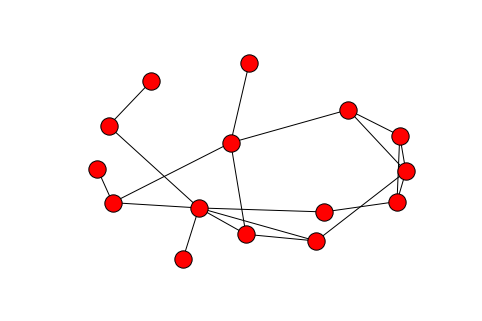

In [8]:
nx.draw(G)

In [10]:
%%timeit
graphs = mcmc(G, -1.25, 0.15, 10000)

1 loop, best of 3: 6.79 s per loop


I fit the ERGM with 100 coefficient iterations and 10,000 random networks for each candidate distribution. I also have it return the full series of steps. Note: this part takes a while.


In [17]:
%%timeit
edge_coeffs, triangle_coeffs, probs = fit_ergm(G, 10, 10, True)

The slowest run took 25.50 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 199 ms per loop


In [21]:
edge_coeffs, triangle_coeffs, probs = fit_ergm(G, 10, 10, True)

In [22]:
i = np.argmax(probs)
print max(probs)
print edge_coeffs[i]
print triangle_coeffs[i]

790.389887025
-0.258330067315
-0.267028910424


Once it's done (about 20 minutes later, for me), we can find the values it converged to. For me, they were:

Edge coefficient: -1.667

Triangle coefficient: -0.258

Not too far off! The edge coefficient is very close; the triangle coefficient is not too far off, and in any case isn't statistically significant.

One problem I discovered is that I obtained some estimated probabilities for the observed network that were greater than 1. This means that the network MCMC was sampling far away from the observed network, so that the weight on the observed network was greater than the sum of weights on all the sampled networks. This isn't a great outcome, though it still does tell us something about how likely the observed network is under that distribution. Increasing the network sample size might help make this problem go away, as would improving the Markov chain procedure (e.g. with more permutation between networks).

We can do a few more diagnostics on the results. For example, the trace of the value of the coefficients at each iteration is:

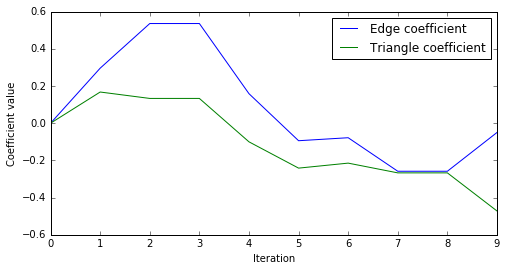

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
p1, = ax.plot(edge_coeffs)
p2, = ax.plot(triangle_coeffs)
ax.set_ylabel("Coefficient value")
ax.set_xlabel("Iteration")
l = ax.legend([p1, p2], ["Edge coefficient", "Triangle coefficient"])

In [24]:
weighted_edge_coeffs = np.array(edge_coeffs[1:]) * np.array(probs[1:])
print np.sum(weighted_edge_coeffs)/np.sum(probs[1:])


-0.257038095555


In [25]:
weighted_tri_coeffs = np.array(triangle_coeffs[1:]) * np.array(probs[1:])
print np.sum(weighted_tri_coeffs)/np.sum(probs[1:])

-0.266541340488


We can also see the distribution of possible coefficients, by making a histogram weighted by the likelihood we observed for each value. (To deal with the likelihoods estimated at greater than 1, I actually weight each coefficient value by the log of the estimated likelihood).

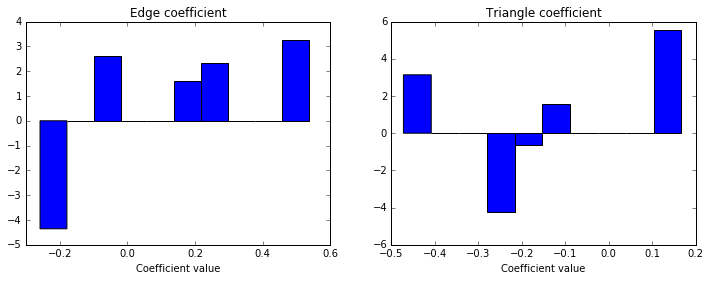

In [26]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.hist(edge_coeffs[1:], weights=-np.log(probs[1:]))
ax1.set_title("Edge coefficient")
ax1.set_xlabel("Coefficient value")

ax2 = fig.add_subplot(122)
ax2.hist(triangle_coeffs[1:], weights=-np.log(probs[1:]))
ax2.set_title("Triangle coefficient")
ax2.set_xlabel("Coefficient value")
plt.show()

This shows that the bulk of the weight on the edge coefficient is between -1 and -2, while the triangle coefficient is much more evenly distributed on both sides of 0. Using a distribution like this, we can statistically test whether the coefficients are significantly different from 0, estimate the standard error, and do various other statistical tests and operations I won't cover here.

And that's it! We have a slow, simplistic but apparently somewhat-working ERGM model fitter, built up from scratch.

If you want to learn how to actually do ERGM analysis in R , Benjamin Lind has a great hands-on tutorial over at Bad Hessian on using ERGMs to model the hookup network on the TV show Grey's Anatomy. The paper introducing the ergm package by Hunter et al., the package developers, is a great guide, as is the (paywalled) An introduction to exponential random graph (p*) models for social networks by Robins et al. Markov Chain Monte Carlo Estimation of Exponential Random Graph Models by Tom Snijders goes into more detail on estimation methodology, and includes an appendix with a much better estimation algorithm, which I may try to implement in the future.

# Analyzing Grey's Anatomy Network with ERGM using PyMC

https://gist.github.com/dmasad/78cb940de103edbee699

In [27]:
from scipy.misc import comb
from itertools import product
import pymc

https://github.com/alexleavitt/SNAinRworkshop

## Loading the data
Unfortunately, the data from the original Grey's Anatomy tutorial seems to be offline. Fortunately, it was preserved on GitHub by Alex Leavitt and Joshua Clark.

The data comes in two tables: the adjacency table gives us the graph itself, and a node attribute table gives us node-level information on each character. Below, I'm going to load both into NetworkX.

## Loading the adjacency table

NetworkX doesn't have a native loader for an adjacency matrix with row and column headers, so here's some code to load it manually.

First, we get the top row; this tell us how many nodes there are, and will be useful for labeling them.

In [28]:
import pandas as pd

In [45]:
df = pd.read_csv('../data/grey_adjacency.tsv', sep = '\t', index_col = 0)
df.iloc[:5, :5]

,addison,adele,altman,amelia,arizona
addison,0,0,0,0,0
adele,0,0,0,0,0
altman,0,0,0,0,0
amelia,0,0,0,0,0
arizona,0,0,0,0,0


In [47]:
adj = df.as_matrix()

In [51]:
G = nx.from_numpy_matrix(adj)
G = nx.relabel_nodes(G, {i: df.index[i] for i in range(44)})


## Loading attributes
The attribute data is in a nice, conventional table: each row is a character, and each column is a character attribute. (See the original tutorial for more information on where this data comes from).
Using Python's built-in csv module, we can read in all the rows as dictionaries, which makes it easy to assign the attributes to the network.

In [56]:
df_nodes = pd.read_csv('../data/grey_nodes.tsv', sep = '\t')
df_nodes.iloc[:5,]

,name,sex,race,birthyear,position,season,sign
0,addison,F,White,1967,Attending,1,Libra
1,adele,F,Black,1949,Non-Staff,2,Leo
2,altman,F,White,1969,Attending,6,Pisces
3,amelia,F,White,1981,Attending,7,Libra
4,arizona,F,White,1976,Attending,5,Leo


In [67]:
node_attributes = []
for i in df_nodes.index:
    node_attributes.append(df_nodes.iloc[i].to_dict())

In [68]:
node_attributes[0]

{'birthyear': 1967,
 'name': 'addison',
 'position': 'Attending',
 'race': 'White',
 'season': 1,
 'sex': 'F',
 'sign': 'Libra'}

Assign the attributes to each node, which are now keyed on the character names:

In [69]:
for node in node_attributes:
    name = node["name"]
    for key, val in node.items():
        if key == "name":
            continue
        G.node[name][key] = val

## Drawing the hookup graph
Now that we have the data loaded in, we can draw the hookup graph. I color the male characters in blue and the female characters in pink (because gender norms).

In [73]:
colors = {"M": "mediumslateblue",
          "F": "hotpink"}
node_colors = [colors[node[1]["sex"]] for node in G.nodes(data=True)]
pos = nx.spring_layout(G, k=0.075, scale=4)

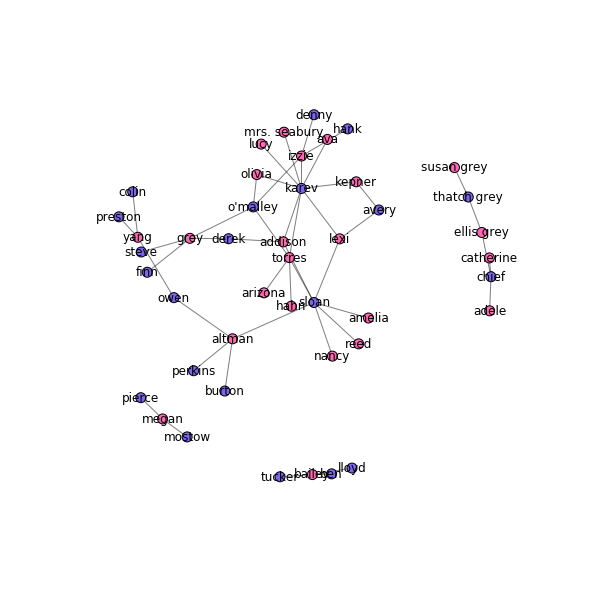

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
plt.axis('off')
plt.show()

## Building the ERGM
Now comes the important part: building and fitting the ERGM with **PyMC**.

To start with, we need to know what model we're actually fitting. I use the simplest one, explaining the network in terms of the number of edges and whether those edges are between nodes with the same gender.

We need two NxN matrices, one for each network statistic. Each cell in each matrix indicates how the presence of that potential edge would change that statistic, holding the rest of the network constant.

For the edge count, the matrix is just all 1s -- since any new edge, by definition, increases the edge count by 1.
Gender matching is a specific example of attribute matching: we want a matrix $M$ such that $m_{i,j}=1$ if nodes $i$ and $j$ have the same attribute value (e.g. their gender), and otherwise $0$.

Now, here's one change we make here from the Social Abstractions tutorial. Unlike the prison friendship network, the hookup graph is undirected -- if $i$ has hooked up with $j$, then $j$ has obviously also hooked up with $i$. That means we really need only one half of each matrix, either the upper or lower triangle. We can zero out the other triangle, to make sure that we can only realize one edge per dyad.

In [78]:
def edge_count(G):
    size = len(G)
    ones = np.ones((size, size))
    # Zero out the upper triangle:
    if not G.is_directed():
        ones[np.triu_indices_from(ones)] = 0
    return ones

In [79]:
def node_match(G, attrib):
    size = len(G)
    attribs = [node[1][attrib] for node in G.nodes(data=True)]
    match = np.zeros(shape=(size, size))
    for i in range(size):
        for j in range(size):
            if i != j and attribs[i] == attribs[j]:
                match[i,j] = 1
    if not G.is_directed():
        match[np.triu_indices_from(match)] = 0
    return match


In [80]:
# Create the gender-match matrix
gender_match_mat = node_match(G, "sex")

Now we bring in PyMC stochastic variables for the coefficients on both statistics matrices. The prior for them can be pretty arbitrary, but we want them to be able to take on any value, either positive or negative, and be centered on 0. So, normal distributions it is.

The actual term for each statistic is the coefficient times the matrix; since these values are wholly dependent on stochastic variables, they are PyMC deterministic variables themselves.

In [95]:
density_coef = pymc.Normal("density", 0, 0.001)
gender_match_coef = pymc.Normal("gender_match", 0, 0.001)

density_term = density_coef * edge_count(G)
gender_match_term = gender_match_coef * gender_match_mat

In [96]:
term_list = [density_term, gender_match_term]

Next, we create the probability matrix, where $p_{i,j}$ is the probability of an edge between $i$ and $j$. This is another PyMC deterministic variable, since the probability is based on the two terms defined above.

We set the upper triangle to 0 here, so that there is only one probability associated with each dyad.

In [97]:
@pymc.deterministic
def probs(term_list=term_list):
    probs = 1/(1+np.exp(-1*sum(term_list))) # The logistic function
    probs[np.diag_indices_from(probs)] = 0
    # Manually cut off the top triangle:
    probs[np.triu_indices_from(probs)] = 0
    return probs

Finally, we create the outcome variable: it's a matrix of Bernoulli random values, one for each potential edge, each realized with probability as determined by our mode. This matrix is actually observed as the network's adjacency matrix. It's this outcome that PyMC will maximize the probability of the model generating.


In [98]:
# Get the adjacency matrix, and zero out the upper triangle
matrix = nx.to_numpy_matrix(G)
matrix[np.triu_indices_from(matrix)] = 0

In [100]:
outcome = pymc.Bernoulli("outcome", probs, value=matrix, observed=True)

In order to view sample networks drawn from the posterior distribution, I add one more random variable: a simulated outcome. This takes the same form as the outcome matrix above, but isn't set as observed. Instead, the value of each potential edge will be randomly drawn based on the probs matrix.

In [101]:
sim_outcome = pymc.Bernoulli("sim_outcome", probs)

## Fitting the model

With all the variables finally set, we can plug them all into a model object, and start the MCMC process.

In [104]:
model = pymc.Model([outcome, sim_outcome, probs, 
                    density_coef, density_term, 
                    gender_match_coef, gender_match_term])

In [105]:
mcmc = pymc.MCMC(model)
mcmc.sample(50000, 1000, 50)

 [-----------------100%-----------------] 50000 of 50000 complete in 29.3 sec

The estimated coefficients and standard errors are computed from the traces:


In [106]:
density_trace = mcmc.trace("density")[:]
gender_match_trace = mcmc.trace("gender_match")[:]

print("Density: {0:.3f}, {1:.3f}".format(np.mean(density_trace), np.std(density_trace)))
print("Gender: {0:.3f}, {1:.3f}".format(np.mean(gender_match_trace), np.std(gender_match_trace)))

Density: -2.307, 0.156
Gender: -3.372, 0.847


These are pretty close to the coefficients and standard errors computed in R, suggesting that the model was specified and fit correctly.
## Diagnostics
The R ergm package can plot some diagnostic charts automatically, to help us make sure the model is not degenerate and that chain is mixing well. I plot similar charts below:

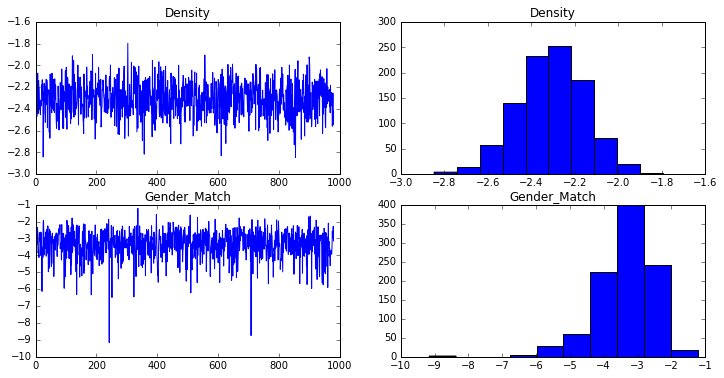

In [107]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax1.plot(density_trace)
ax1.set_title("Density")
ax2 = fig.add_subplot(222)
ax2.hist(density_trace)
ax2.set_title("Density")

ax3 = fig.add_subplot(223)
ax3.plot(gender_match_trace)
ax3.set_title("Gender_Match")
ax4 = fig.add_subplot(224)
ax4.hist(gender_match_trace)
ax4.set_title("Gender_Match")
plt.show()

## Checking the goodness-of-fit

One way to inspect the goodness-of-fit of the model is to take a random realization of the network from the posterior distribution, and see how it compares to the observed network. This is one of the things we can do with the sim_outcome variable we added to the model.

In [108]:
realization = mcmc.trace("sim_outcome")[-1] # Take the last one


Or you can fix the coefficients and draw at random:


In [109]:
# density_coef.value = np.mean(density_trace)
# gender_match_coef.value = np.mean(gender_match_trace)
#realization = sim_outcome.random()

Convert the realized matrix to a full network, and add the node attributes:


In [111]:
sim_g = nx.from_numpy_matrix(realization)

sim_g = nx.relabel_nodes(sim_g, {i: df.index[i] for i in range(44)})
for node in node_attributes:
    name = node["name"]
    for key, val in node.items():
        if key == "name":
            continue
        sim_g.node[name][key] = val

And visualize. We don't care about the individuals here, since our model was only looking at the gender matching:


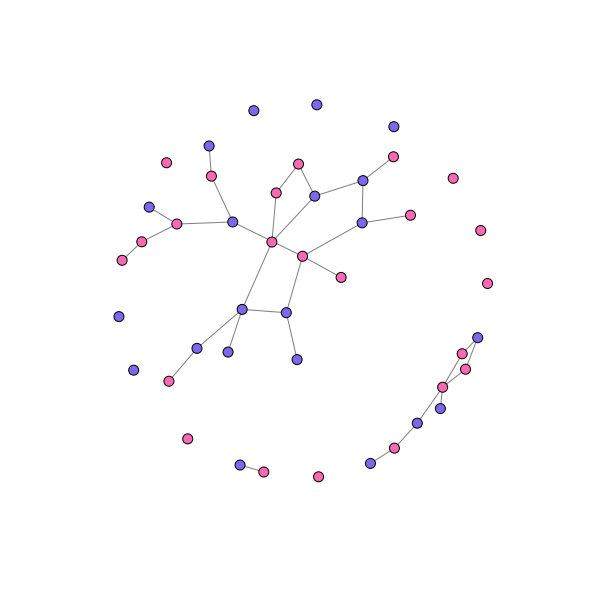

In [113]:

colors = {"M": "mediumslateblue",
          "F": "hotpink"}
node_colors = [colors[node[1]["sex"]] for node in sim_g.nodes(data=True)]

pos = nx.spring_layout(sim_g, k=0.075, scale=4)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(sim_g, pos, node_size=100, node_color=node_colors, ax=ax)
nx.draw_networkx_edges(sim_g, pos, alpha=0.5, ax=ax)
#nx.draw_networkx_labels(sim_g, pos, ax=ax)

_ = ax.axis('off')

This graph looks 'about right' (a really scientific assessment), and the model seems to be capturing a lot of the tendency towards heterosexual pairings (though there appear to be more same-sex pairs, and especially pairs of women, than observed in the actual data). There are also more singletons than observed in the actual data -- though about as many as produced by the R model.
## Degree distribution
Another way of assessing the goodness-of-fit is comparing the degree distribution of the simulated networks to the observed one. The R ergm package has that built in, but here we have to do it ourselves.
To do it, we count the number of nodes of each degree in the observed network, and across all of the simulated networks, and plot them together.

In [114]:
from collections import defaultdict, Counter



Observed degree distribution:

In [115]:

obs_deg_freq = Counter(nx.degree(G).values())
x = list(obs_deg_freq.keys())
y = list(obs_deg_freq.values())



Simulated degree distributions:

In [116]:
deg_freq = defaultdict(list)
# We don't care about node properties here, just the degree.
for realization in mcmc.trace("sim_outcome")[:]:
    sim_g = nx.from_numpy_matrix(realization)
    for deg, count in Counter(nx.degree(sim_g).values()).items():
        deg_freq[deg].append(count)
        
vals = list(deg_freq.values())
labels = list(deg_freq.keys())

And finally, plot: black dots for the observed degree count, box-and-whiskers plots for the distributions.


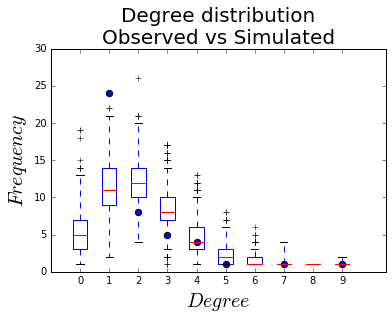

In [119]:
fig, ax = plt.subplots()

h = ax.boxplot(vals, positions=labels)
ax.scatter(x, y, s=40)
ax.set_xlim(-1, 10.5)
ax.set_ylim(0, 30)
ax.set_xticklabels(labels)
ax.set_xlabel("$Degree$", fontsize = 20)
ax.set_ylabel("$Frequency$", fontsize = 20)
ax.set_title("Degree distribution\nObserved vs Simulated", fontsize = 20)

plt.show()

# Exponential random graph models in python

http://socialabstractions-blog.tumblr.com/post/53391947460/exponential-random-graph-models-in-python

For readers unfamiliar with ERGM, it is a modeling framework for network or graph data. An unfortunate fact of statistical inference on networks is that the independence assumptions of ordinary least squares are violated in deep, complex and interconnected ways (one of the core insights of social network analysis is that whether or not I am friends with you is tightly related to whether or not I am friends with your friends). ERGMs attempt to bring a linear modeling approach to network estimation by assuming that these inherent interdependencies depend mostly on network characteristics that a savvy modeler can explicitly specify. If you have reason to believe that the major network dependencies in your data can be controlled for by reciprocity and transitivity, for instance, you can simply include those terms in your model specification and hope (read: assume) that the rest of your errors are independent. While they are not perfect, ERGMs have become a widely accepted method among social network analysts.


Most often, ERGMs are estimated using the ergm package for the R statistical environment. This is a wonderful package put together by many of the top researchers in the field of network inference. 

Recently I needed to estimate a model that allowed more low-level control of the modelling than this package allowed however, so I turned to PyMC to see if I could implement ERGM estimation myself. 

PyMC is an invaluable python package that makes Markov-chain Monte-Carlo (MCMC) estimation straightforward and, importantly, very fast to implement. Getting estimates for pretty much any model in PyMC takes barely any more work than just specifying that model, and it’s well designed enough that writing your own step methods (and even sampling algorithms) in python is a snap.

## Gagnon & MacRae prison friendship network
As a sanity check on my work, I decided to estimate the same model on the same data with  ergm in R and then with PyMC in python. The data I used is the prison friendship network from Gagnon & MacRae1, which I got from the UCINET IV datasets page. I was only interested in directed friendship ties between inmates, so I discarded any information about the prisoners themselves; you can download my cleaned up adjacency matrix

## The Model
I specify a pretty simple model for the network. I use Y to refer to the adjacency matrix of the network and $y_{i,j}$ to refer to the (i,j)th element of Y. The value of $y_{i,j}$ is one if prisoner i listed prisoner j as a friend, and zero otherwise. The ERGM is specified as

$$Pr(Y|θ)∝exp[θ′Ψ(Y)]$$

where θ is our vector of coefficients, and $Ψ(Y)$ is a vector of network statistics on Y. With ERGMs, $Ψ$ is where the modeler includes all of the statistics she deems relevant to the network ties. I include a few straightforward statistics:


### mutual tie count:
The number of pairs in the network for which both of the directed edges (i,j) and (j,i) exist. (How many pairs of prisoners mutually nominated each other as friends)
### density:
The total number of edges present in the graph. (How many total friendship nominations were made)
### 2-instar count:
The total number of nodes with exactly two incoming edges. (How many prisoners were listed as friends by exactly two other prisoners)
### 3-instar count:
The total number of nodes with exactly three incoming edges. (How many prisoners were listed as friends by exactly three other prisoners)
### 2-outstar count:
The total number of nodes with exactly two outgoing edges. (How many prisoners listed exactly two other prisoners as friends)

library(ergm)

prisonAdj <- matrix(scan('prison.dat'),nrow=67,byrow=T)

prisonNet <- network(prisonAdj)

prisonEst <- ergm(prisonNet ~ mutual+istar(1:3)+ostar(2))

## Estimating in python
A standard result from ERGMs can be reduced to a simple logistic regression with a case for each edge in the network. 

**In this case, each covariate represents the change in a particular network statistic if the edge in question were present versus not present. **

Formally, let $Y_{i,j}^+$ be the network obtained by setting $y_{i,j}=1$ in Y, and let $Y_{i,j}^-$ be the network obtained by setting $y_{i,j}=0$. 

For a particular network statistic $Φ_k(Y)$ the corresponding change statistic for edge (i,j) is defined as $$ϕ_k(Y,i,j)=Φ_k(Y_{i,j}^+)−Φ_k(Y_{i,j}^-)$$ 

So for edge (i,j) the change in the mutual edge count, $ϕ_M(Y,i,j)$ would depend on the value of $y_{j,i}$. If$y_{j,i} = 0$, then holding the rest of the network fixed edge (i,j) would be unable to change the total mutual edge count, so $ϕ(Y,i,j)=0$. If $y_{j,i}=1$, then $y_{i,j}$ would determine whether the edge was mutual and $ϕ(Y,i,j)=1$.

The first step in the python implementation, then, is to construct these ϕ covariates for each of our network statistics.

In [120]:
import scipy as sp
from scipy.misc import comb
from itertools import product
from pymc import  Normal, Bernoulli, InvLogit, MCMC,MAP,deterministic

# functions to get delta matrices
def mutualDelta(am):
    return(am.copy().transpose())

def istarDelta(am,k):
    if k == 1:
        # if k == 1 then this is just density
        res = sp.ones(am.shape)
        return(res)
    res = sp.zeros(am.shape,dtype=int)
    n = am.shape[0]
    for i,j in product(xrange(n),xrange(n)):
        if i!=j:
            nin = am[:,j].sum()-am[i,j]
            res[i,j] = comb(nin,k-1,exact=True)
    return(res)

def ostarDelta(am,k):
    if k == 1:
        # if k == 1 then this is just density
        res = sp.ones(am.shape)
        return(res)
    res = sp.zeros(am.shape,dtype=int)
    n = am.shape[0]
    for i,j in product(xrange(n),xrange(n)):
        if i!=j:
            nin = am[i,:].sum()-am[i,j]
            res[i,j] = comb(nin,k-1,exact=True)
    return(res)


def makeModel(adjMat):

    # define and name the deltas
    termDeltas = {
        'deltamutual':mutualDelta(adjMat),
        'deltaistar1':istarDelta(adjMat,1),
        'deltaistar2':istarDelta(adjMat,2),
        'deltaistar3':istarDelta(adjMat,3),
        'deltaostar2':ostarDelta(adjMat,2)
    }

    # create term list with coefficients
    termList = []
    coefs = {}
    for dName,d in termDeltas.items():
        tName = 'theta'+dName[5:]
        coefs[tName] = Normal(tName,0,0.001,value=sp.rand()-0.5)
        termList.append(d*coefs[tName])

    # get individual edge probabilities
    @deterministic(trace=False,plot=False)
    def probs(termList=termList):
        probs = 1./(1+sp.exp(-1*sum(termList)))
        probs[sp.diag_indices_from(probs)]= 0
        return(probs)

    # define the outcome as 
    outcome = Bernoulli('outcome',probs,value=adjMat,observed=True)

    return(locals())

In [124]:
# load the prison data
with open('../data/prison_mod.dat','r') as f:
    rowList = list()
    for l in f:
        rowList.append([int(x) for x in l.strip().split(' ')])
    adjMat = sp.array(rowList)

# make the model as an MCMC object
m = makeModel(adjMat)
mc = MCMC(m)

# estimate
mc.sample(30000,1000,50)

 [-----------------100%-----------------] 30000 of 30000 complete in 34.6 sec

In [142]:
mc.tName

'thetaostar2'

In [143]:
mc.trace("thetamutual")[:5]

array([ 3.6531157 ,  3.73607108,  3.54492143,  3.85161951,  3.31308036])

In [148]:
mutual_trace = mc.trace("thetamutual")[:]
istar1_trace = mc.trace("thetaistar1")[:]
istar2_trace = mc.trace("thetaistar2")[:]
istar3_trace = mc.trace("thetaistar3")[:]
ostar2_trace = mc.trace("thetaostar2")[:]


print("mutual: {0:.3f}, {1:.3f}".format(np.mean(mutual_trace), np.std(mutual_trace)))
print("density: {0:.3f}, {1:.3f}".format(np.mean(istar1_trace), np.std(istar1_trace)))
print("istar2: {0:.3f}, {1:.3f}".format(np.mean(istar2_trace), np.std(istar2_trace)))
print("istar3: {0:.3f}, {1:.3f}".format(np.mean(istar3_trace), np.std(istar3_trace)))
print("ostar2: {0:.3f}, {1:.3f}".format(np.mean(ostar2_trace), np.std(ostar2_trace)))

mutual: 3.567, 0.178
density: -4.478, 0.266
istar2: 0.447, 0.117
istar3: -0.090, 0.038
ostar2: -0.054, 0.060


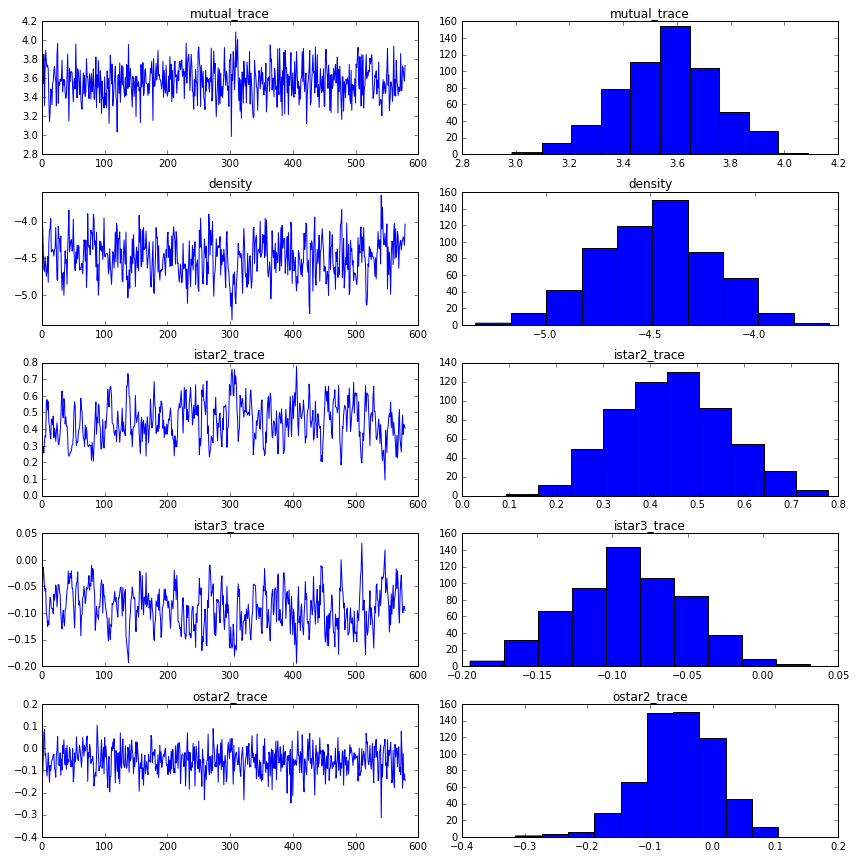

In [150]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(521)
ax1.plot(mutual_trace)
ax1.set_title("mutual_trace")
ax2 = fig.add_subplot(522)
ax2.hist(mutual_trace)
ax2.set_title("mutual_trace")

ax3 = fig.add_subplot(523)
ax3.plot(istar1_trace)
ax3.set_title("density")
ax4 = fig.add_subplot(524)
ax4.hist(istar1_trace)
ax4.set_title("density")

ax5 = fig.add_subplot(525)
ax5.plot(istar2_trace)
ax5.set_title("istar2_trace")
ax6 = fig.add_subplot(526)
ax6.hist(istar2_trace)
ax6.set_title("istar2_trace")

ax7 = fig.add_subplot(527)
ax7.plot(istar3_trace)
ax7.set_title("istar3_trace")
ax8 = fig.add_subplot(528)
ax8.hist(istar3_trace)
ax8.set_title("istar3_trace")

ax9 = fig.add_subplot(529)
ax9.plot(ostar2_trace)
ax9.set_title("ostar2_trace")
ax10 = fig.add_subplot(5,2,10)
ax10.hist(ostar2_trace)
ax10.set_title("ostar2_trace")
plt.tight_layout()
plt.show()

In [154]:
22980/365

62